# Symeonidis+16 Intrinsic AGN SED

In this notebook, I want to explore what the effect of assuming the AGN SED can extend to longer wavelengths would do to our estimates of LAGN and LSF. I've downloaded the Symeonidis+16 SED and saved it as 'symeonidis16_intrinsicAGN_template.txt' in the data directory for the paper. The units are arbitrary in nuLnu space.

In [13]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
plt.rc("font", size=24, family="sans-serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
%matplotlib inline

In [3]:
sy16_data = np.loadtxt('../data/symeonidis16_intrinsicAGN_template.txt')
sy16_waves = sy16_data[:,0]        # Wavelengths
sy16_nu = 3e14/sy16_waves          # Convert to frequency
sy16_nulnu = sy16_data[:,1]        # median nuLnu
sy16_nulnu_16 = sy16_data[:,2]     # 16%tile nuLnu
sy16_nulnu_84 = sy16_data[:,3]     # 84%tile nuLnu
sy16_lnu = 10**sy16_nulnu/sy16_nu      # Convert to Lnu
sy16_lnu_16 = 10**sy16_nulnu_16/sy16_nu
sy16_lnu_84 = 10**sy16_nulnu_84/sy16_nu

Let's make sure we've uploaded and converted everything correctly by plotting the SED.

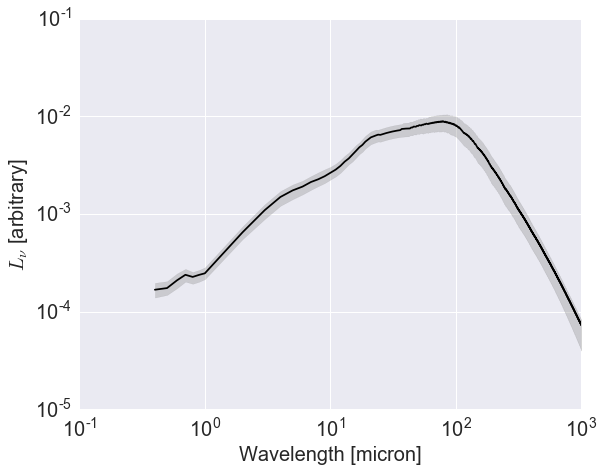

In [14]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)
ax.loglog(sy16_waves, sy16_lnu, 'k-')
ax.fill_between(sy16_waves, sy16_lnu_16, sy16_lnu_84, color='gray', alpha=0.3)
ax.set_xlabel('Wavelength [micron]')
ax.set_ylabel(r'$L_{\nu}$ [arbitrary]')

Yup, everything looks good. Now I need to fit the SED with an exponentially cutoff powerlaw. First I need to define a function that calculates this model.

In [77]:
def expo_cut_plaw(x, norm, lambda_turn):
    
    return norm * (x/lambda_turn) * np.exp(-(x/lambda_turn)**2)

Let's make sure the function is working correctly. We'll give it parameters of norm=1, alpha=1, lambda_turn=45.

(1e-06, 2)

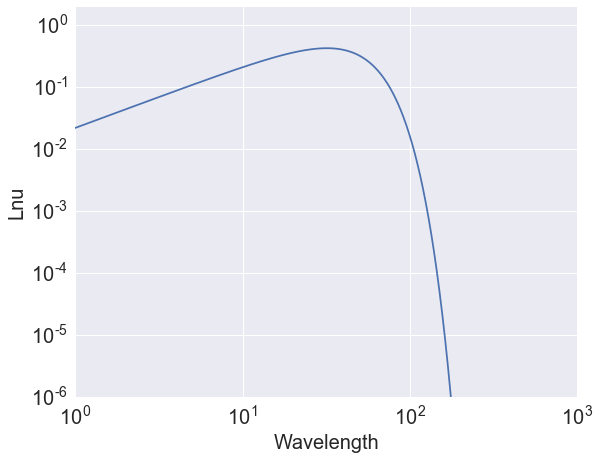

In [19]:
norm = 1.0
alpha = 1.0
lturn = 45.0

x = np.arange(1, 1000)
y = expo_cut_plaw(x, norm, alpha, lturn)

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)
ax.loglog(x, y)
ax.set_xlabel('Wavelength')
ax.set_ylabel('Lnu')
ax.set_ylim(10**(-6), 2)

Ok everything looks good for the exponentially cutoff powerlaw. Interestingly, it looks like it falls much more rapidly than the Symeonidis+16 intrinsic SED. But we'll see what kind of fit we can get. I'll just use the Scipy 'curve_fit' function to quickly do a fit.

In [78]:
import scipy.optimize as opt

p0 = [10**(-2), 100.]
popt, pcov = opt.curve_fit(expo_cut_plaw, sy16_waves, sy16_lnu)
print 'Best Fit Norm = ', popt[0]
print 'Best Fit lambda_turn = ', popt[1]

Best Fit Norm =  0.0210917134575
Best Fit lambda_turn =  117.867308608


(1e-06, 0.01)

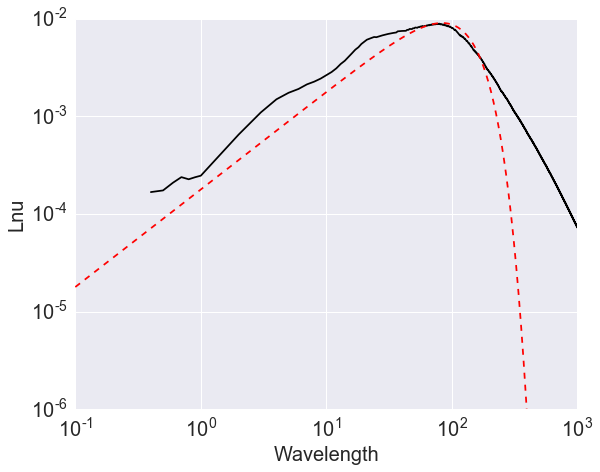

In [80]:
xfit = 10**np.arange(-1, 3, 0.01)
yfit = expo_cut_plaw(xfit, popt[0], popt[1])

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)
ax.loglog(sy16_waves, sy16_lnu, 'k-')
ax.loglog(xfit, yfit, 'r--')
ax.set_xlabel('Wavelength')
ax.set_ylabel('Lnu')
ax.set_ylim(10**(-6), 10**(-2))

It's clear that our model is falling too steeply after the turnover wavelength. This is affecting the MIR slope and is shown as an excess in the intrinsic Symeonidis+16 SED. We can adjust the steepness of the FIR part by allowing the exponent in the argument of the exponential to freely vary so I need to define a new function.

In [64]:
def expo_cut_plaw_new(x, norm, alpha, lambda_turn, exp_slope):
    
    return norm * (x)**alpha * np.exp(-(x/lambda_turn)**exp_slope)

In [65]:
p0 = [10**(-2), 1.0, 100., 0.5]
popt, pcov = opt.curve_fit(expo_cut_plaw_new, sy16_waves, sy16_lnu)
print 'Best Fit Norm = ', popt[0]
print 'Best Fit alpha = ', popt[1]
print 'Best Fit lambda_turn = ', popt[2]
print 'Best Fit Exponential Slope = ', popt[3]

Best Fit Norm =  0.000114068922103
Best Fit alpha =  1.87353444673
Best Fit lambda_turn =  7.19815548888
Best Fit Exponential Slope =  0.567794518128


(1e-06, 0.01)

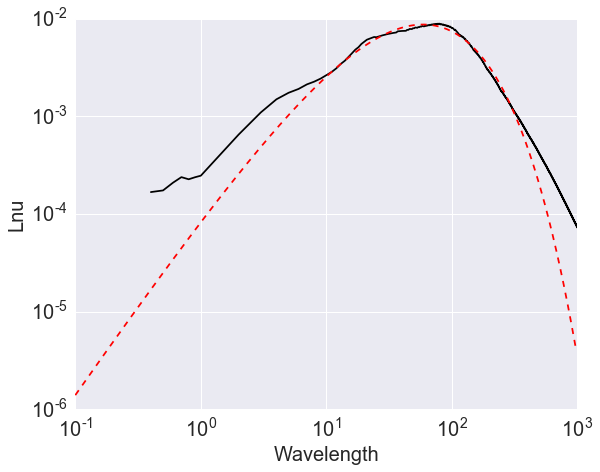

In [66]:
xfit = 10**np.arange(-1, 3, 0.01)
yfit = expo_cut_plaw_new(xfit, popt[0], popt[1], popt[2], popt[3])

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)
ax.loglog(sy16_waves, sy16_lnu, 'k-')
ax.loglog(xfit, yfit, 'r--')
ax.set_xlabel('Wavelength')
ax.set_ylabel('Lnu')
ax.set_ylim(10**(-6), 10**(-2))

This helped a little bit but now the model is underestimating the short and longwavelength data. Let's try fixing alpha to 1.0. 

In [72]:
def expo_cut_plaw_fix_alpha(x, norm, lambda_turn, exp_slope):
    
    return norm * (x/lambda_turn) * np.exp(-(x/lambda_turn)**exp_slope)

In [73]:
p0 = [10**(-2), 100., 0.5]
popt, pcov = opt.curve_fit(expo_cut_plaw_fix_alpha, sy16_waves, sy16_lnu)
print 'Best Fit Norm = ', popt[0]
print 'Best Fit lambda_turn = ', popt[1]
print 'Best Fit Exponential Slope = ', popt[2]

Best Fit Norm =  0.0230376575731
Best Fit lambda_turn =  56.7155055202
Best Fit Exponential Slope =  0.931275947977


(1e-05, 0.01)

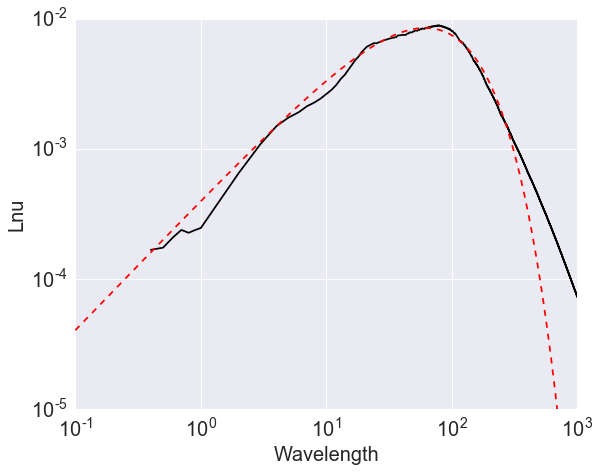

In [74]:
xfit = 10**np.arange(-1, 3, 0.01)
yfit = expo_cut_plaw_fix_alpha(xfit, popt[0], popt[1], popt[2])
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)
ax.loglog(sy16_waves, sy16_lnu, 'k-')
ax.loglog(xfit, yfit, 'r--')
ax.set_xlabel('Wavelength')
ax.set_ylabel('Lnu')
ax.set_ylim(10**(-5), 10**(-2))

This is much better than before but we are still underestimating the very longwavelength emission. The problem here seems to be that the functional form is not an exponential but rather a powerlaw. So I think the best course of action is to use the SED combined with the starburst templates in DecompIR and see how the AGN fraction changes by forcing the AGN intrinsic SED to be the Symeonidis+16 SED. I reran the DecompIR fitting for all sources with >= 4 detected SED points using this AGN SED. I extracted and saved all of the best fit results in the sb+sy16 directory in the decompir_results folder.

In [81]:
sy16_decomp_results = pd.read_csv('../../bat-agn-sed-fitting/analysis/decompir_results/sb+sy16/final_fit_results_decompir_sb_and_sy16.csv', index_col=0)

In [83]:
sy16_decomp_results

,agn_frac,agn_name,agn_norm,chi2,host_name,host_norm,lir_total
Name,,,,,,,
1RXSJ044154.5-082639,4.805225e-01,Sy16,-1.965746,-18.038949,SB4,-3.014576,10.376803
1RXSJ045205.0+493248,6.351032e-01,Sy16,-1.402797,-7.734857,SB1,-2.315388,10.446941
2E1739.1-1210,7.037570e-01,Sy16,-1.180575,-8.263530,SB1,-2.228267,10.841322
2MASXiJ1802473-145454,3.225013e-01,Sy16,-1.387247,-3.121864,SB5,-2.370477,10.923996
2MASXJ00253292+6821442,8.426556e-01,Sy16,-1.329097,-12.060931,SB1,-2.729813,9.620300
2MASXJ01064523+0638015,9.352560e-01,Sy16,-1.567726,-13.081157,SB4,-3.810140,10.422370
2MASXJ01073963-1139117,3.815456e-01,Sy16,-1.640152,-13.301373,SB5,-2.735998,10.870473
2MASXJ03305218+0538253,9.692468e-01,Sy16,-1.351158,-9.251034,SB3,-3.970414,10.726541
2MASXJ03342453-1513402,2.502907e-01,Sy16,-1.787422,-8.523446,SB5,-2.616581,10.632330


Now let's get the results using the "Mean" AGN SED from Mullaney+11.

In [84]:
decompir_results = pd.read_csv('../../bat-agn-sed-fitting/analysis/decompir_results/sb+arp220/final_fit_results_decompir_sb_and_arp220_v2.csv', index_col=0)

In [86]:
decompir_results

,agn_frac,agn_name,agn_norm,chi2,host_name,host_norm,lir_total
Name,,,,,,,
1RXSJ044154.5-082639,0.527092,Mean,-2.184580,-18.472054,SB2,-2.935343,10.361519
1RXSJ045205.0+493248,0.594394,Mean,-1.659236,-8.764159,SB1,-2.253398,10.462997
2E1739.1-1210,0.647544,Mean,-1.446085,-8.318079,SB1,-2.138442,10.855690
2MASSJ07594181-3843560,1.000000,Mean,-2.056958,13.597327,SB5,-19.913989,10.125711
2MASSJ17485512-3254521,0.512577,Mean,-2.423791,-9.609303,SB1,-2.873838,9.434177
2MASXiJ1802473-145454,0.242567,Mean,-1.786798,-1.162636,SB2,-1.995937,8.846013
2MASXJ00253292+6821442,0.784282,Mean,-1.578958,-12.016661,SB1,-2.567736,9.645340
2MASXJ01064523+0638015,0.826996,Mean,-1.842023,-14.750761,SB3,-3.398458,10.445224
2MASXJ01073963-1139117,0.352664,Mean,-1.905913,-12.655187,SB5,-2.704027,10.882621


We need to merge the two tables together. All I really care about is a comparison between the AGN luminosity.

In [104]:
sy16_decomp_results['lagn'] = np.log10(sy16_decomp_results['agn_frac']) + sy16_decomp_results['lir_total']
decompir_results['lagn'] = np.log10(decompir_results['agn_frac']) + decompir_results['lir_total']
sy16_decomp_results['lagn_decomp'] = decompir_results['lagn']
sy16_decomp_results['agn_frac_decomp'] = decompir_results['agn_frac']

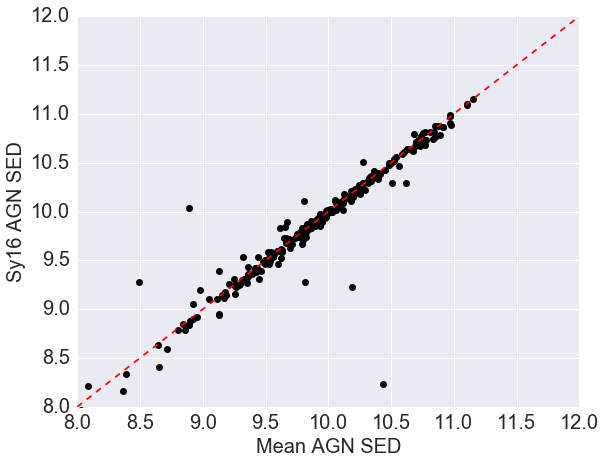

In [94]:
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111)
ax.plot(sy16_decomp_results['lagn'], sy16_decomp_results['lagn_decomp'], 'ko')
ax.set_xlim(8, 12)
ax.set_ylim(8, 12)
ax.set_xlabel('Mean AGN SED')
ax.set_ylabel('Sy16 AGN SED')

x = np.arange(8, 12.0, 0.01)
ax.plot(x, x, 'r--')

The two AGN luminosities look quite correlated with very little offset between them. Let's see the distribution of the ratio between the two.

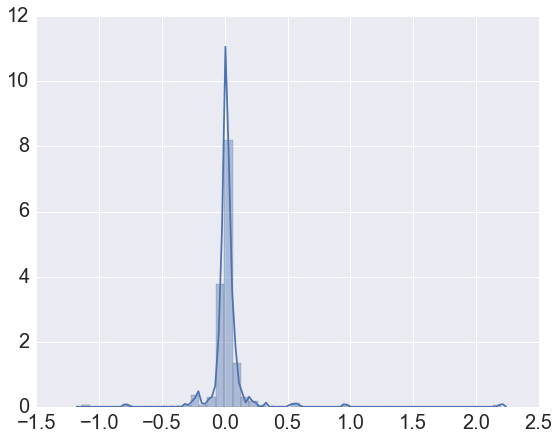

In [98]:
fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111)
sn.distplot(sy16_decomp_results['lagn'][sy16_decomp_results['lagn'] > 8.0]-sy16_decomp_results['lagn_decomp'][sy16_decomp_results['lagn'] > 8.0])

In [103]:
print 'Median offset = ',np.median(sy16_decomp_results['lagn'][sy16_decomp_results['lagn'] > 8.0]-sy16_decomp_results['lagn_decomp'][sy16_decomp_results['lagn'] > 8.0])
print 'Spread offset = ',np.std(sy16_decomp_results['lagn'][sy16_decomp_results['lagn'] > 8.0]-sy16_decomp_results['lagn_decomp'][sy16_decomp_results['lagn'] > 8.0])

Median offset =  0.010225262746
Spread offset =  0.192585327489


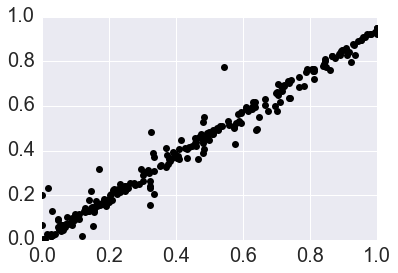

In [105]:
plt.plot(sy16_decomp_results['agn_frac'], sy16_decomp_results['agn_frac_decomp'], 'ko')

So it looks like using the Symeonidis+16 intrinsic AGN SED does not change much about the AGN luminosity, if at all. The median difference between the two is only 0.01 dex and the standard deviation is only 0.2 dex which is within the uncertainty we calculate between all three of our models.